This tutorial introduces sentiment analysis (SA) and shows how to perform a SA in R.

This tutorial is aimed at beginners and intermediate users of R with the aim of showcasing how to perform SA on textual data using R. The aim is not to provide a fully-fledged analysis but rather to show and exemplify selected useful methods associated with sentiment detection, analysis, and visualization.

This notebook has been adapted from the [LADAL SA tutorial](https://ladal.edu.au/sentiment.html).

# What is Sentiment Analysis?

Sentiment Analysis (SA) extracts information on emotion or opinion from natural language (Silge and Robinson 2017). Most forms of SA provides information about positive or negative polarity, e.g. whether a tweet is positive or negative. As such, SA represents a type of classifier that assigns values to texts. As most SA only provide information about polarity, SA is often regarded as rather coarse-grained and, thus, rather irrelevant for the types of research questions in linguistics.

In the language sciences, SA can also be a very helpful tool if the type of SA provides more fine-grained information. In the following, we will perform such a information-rich SA. The SA used here does not only provide information about polarity but it will also provide association values for eight core emotions.

The more fine-grained output is made possible by relying on the Word-Emotion Association Lexicon (Mohammad and Turney 2013), which comprises 10,170 terms, and in which lexical elements are assigned scores based on ratings gathered through the crowd-sourced Amazon Mechanical Turk service. For the Word-Emotion Association Lexicon raters were asked whether a given word was associated with one of eight emotions. The resulting associations between terms and emotions are based on 38,726 ratings from 2,216 raters who answered a sequence of questions for each word which were then fed into the emotion association rating (cf. Mohammad and Turney 2013). Each term was rated 5 times. For 85 percent of words, at least 4 raters provided identical ratings. For instance, the word cry or tragedy are more readily associated with SADNESS while words such as happy or beautiful are indicative of JOY and words like fit or burst may indicate ANGER. This means that the SA here allows us to investigate the expression of certain core emotions rather than merely classifying statements along the lines of a crude positive-negative distinction.


# Preparation and session set up

This tutorial is based on R. If you have not installed R or are new to it, you will find an introduction to and more information [how to use R here](https://slcladal.github.io/intror.html). For this tutorial, we need to install certain packages from an R library so that the scripts shown below are executed without errors. Before turning to the code below, please install the packages by running the code below this paragraph. If you have already installed the packages mentioned below, then you can skip ahead and ignore this section. To install the necessary packages, simply run the following code - it may take some time (between 1 and 5 minutes to install all of the packages so you do not need to worry if it takes some time).


In [ ]:
install.packages("dplyr")
install.packages("stringr")
install.packages("ggplot2")
install.packages("textdata")
install.packages("tidytext")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Now that we have installed the packages, we activate them.

In [ ]:
library(dplyr)
library(stringr)
library(ggplot2)
library(textdata)
library(tidytext)

## Loading data

In the following cell, we will load data and create separate texts for each author group.

In [ ]:
# Load data
senate_data_csv <- read.csv('https://cloudstor.aarnet.edu.au/plus/s/qgGU1srniF6yQsO/download')

# Join text from each author group 
fed_gov_text <- paste(subset(senate_data_csv, Category == "FedGov")[,7], collapse = ' ')
hed_text <- paste(subset(senate_data_csv, Category == "HEd")[,7], collapse = ' ')
individ_text <- paste(subset(senate_data_csv, Category == "Individ")[,7],collapse = ' ')
loc_gov_text <- paste(subset(senate_data_csv, Category == "LocalGov")[,7], collapse = ' ')
ngo_text <- paste(subset(senate_data_csv, Category == "NGO")[,7], collapse = ' ')

## Cleaning the data

The data is messy, and needs to be cleaned. This function performs a range of cleaning steps, including making the data lowercase, removing extra spaces, stripping *stop words* and removing all non-word content (such as punctuation and numbers). The function also splits the text into individual words. 

In [ ]:
txtclean <- function(x, author){
  require(dplyr)
  require(stringr)
  x <- x %>%
    iconv(to = "UTF-8") %>%
    base::tolower() %>%
    paste0(collapse = " ") %>%
    stringr::str_squish()%>%
    stringr::str_split(" ") %>%
    unlist() %>%
    tibble() %>%
    dplyr::select(word = 1, everything()) %>%
    dplyr::mutate(author = author) %>%
    dplyr::anti_join(stop_words) %>%
    dplyr::mutate(word = str_remove_all(word, "\\W")) %>%
    dplyr::filter(word != "")
}

Now we can clean the five texts. In this step we will also add a count of the number of words in each text. This count value will be used later to determine SA percentages.

In [ ]:
# Adding word count here is different from the LADAL notebooks which uses a sum of all words, not per-author
fed_gov_text_clean <- txtclean(fed_gov_text, "fed gov") %>%
  dplyr::mutate(words = n())

hed_text_clean <- txtclean(hed_text, "hed") %>%
  dplyr::mutate(words = n())

individ_text_clean <- txtclean(individ_text, "individ") %>%
  dplyr::mutate(words = n())

loc_gov_text_clean <- txtclean(loc_gov_text, "loc gov") %>%
  dplyr::mutate(words = n())

ngo_text_clean <- txtclean(ngo_text, "ngo") %>%
  dplyr::mutate(words = n())

# Inspect the data
head(ngo_text_clean, 10)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


word,author,words
<chr>,<chr>,<int>
indicators,ngo,176299
of,ngo,176299
impact,ngo,176299
of,ngo,176299
regional,ngo,176299
inequality,ngo,176299
australia,ngo,176299
law,ngo,176299
council,ngo,176299


# Basic Sentiment Analysis 

In this step, a [lexicon of words and their emotions](http://saifmohammad.com/WebPages/lexicons.html) is downloaded, and the respective emotions are added to the texts for each word. 

In [ ]:
# Explicitly create cache dir to prevent download failing due to dir not existing
dir.create("/root/.cache/textdata/nrc", recursive = TRUE)
textdata:::download_functions$nrc(file.path(rappdirs::user_cache_dir("textdata"), "nrc"))
nrc <- textdata::lexicon_nrc(manual_download = TRUE)


Warning message in dir.create("/root/.cache/textdata/nrc", recursive = TRUE):
“'/root/.cache/textdata/nrc' already exists”


In [ ]:
# Combine the word lists and include the sentiment for each word using `left_join`
senate_data <- rbind(
    fed_gov_text_clean, 
    hed_text_clean, 
    individ_text_clean,
    loc_gov_text_clean,
    ngo_text_clean) %>%
  dplyr::left_join(nrc) %>%
  dplyr::group_by(author) %>%
  dplyr::group_by(author, sentiment)

head(senate_data, 10)

Joining, by = "word"


word,author,words,sentiment
<chr>,<chr>,<int>,<chr>
regional,fed gov,14680,NA
inequality,fed gov,14680,anger
inequality,fed gov,14680,fear
inequality,fed gov,14680,negative
inequality,fed gov,14680,sadness
australia,fed gov,14680,NA
submission,fed gov,14680,NA
84,fed gov,14680,NA
australian,fed gov,14680,NA


We will now summarize the results of the SA and calculate the percentages of the prevalence of emotions across the books.

In [ ]:
senate_data_summary = dplyr::summarise(senate_data, 
                                       sentiment = unique(sentiment),
                                       sentiment_freq = n(),
                                       words = unique(words)) %>%
  dplyr::filter(is.na(sentiment) == F) %>%
  dplyr::mutate(percentage = round(sentiment_freq/words*100, 1))

head(senate_data_summary, 10)

`summarise()` has grouped output by 'author'. You can override using the
`.groups` argument.


author,sentiment,sentiment_freq,words,percentage
<chr>,<chr>,<int>,<int>,<dbl>
fed gov,anger,149,14680,1.0
fed gov,anticipation,551,14680,3.8
fed gov,disgust,66,14680,0.4
fed gov,fear,268,14680,1.8
fed gov,joy,325,14680,2.2
fed gov,negative,483,14680,3.3
fed gov,positive,1645,14680,11.2
fed gov,sadness,270,14680,1.8
fed gov,surprise,63,14680,0.4


After performing the SA, visualize the results and show the scores from each core emotion by author group.

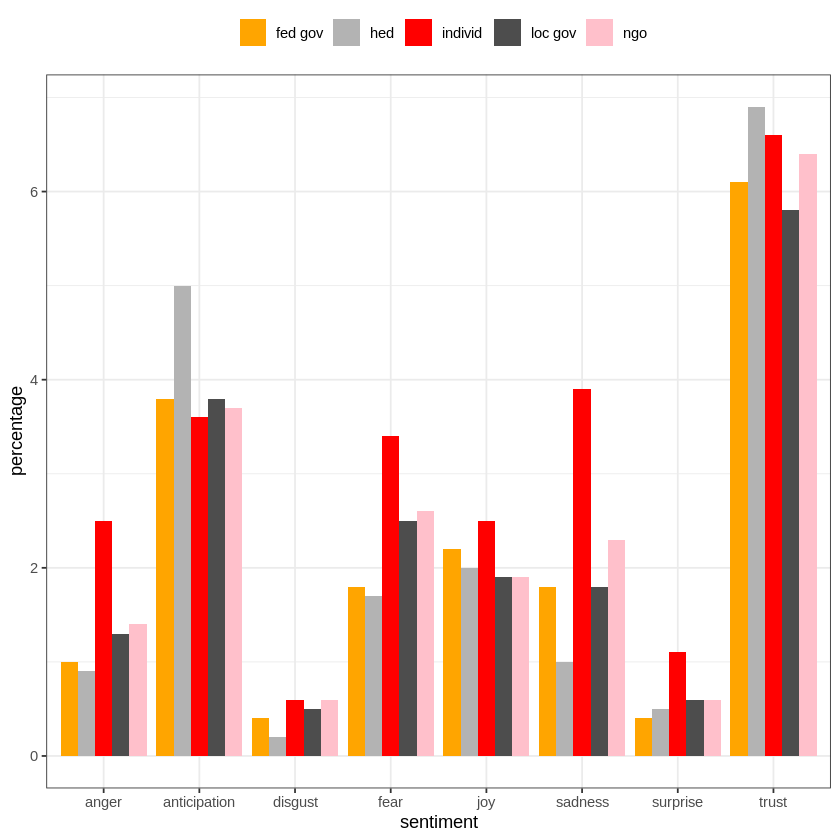

In [ ]:
senate_data_summary %>%
  dplyr::filter(sentiment != "positive",
                sentiment != "negative") %>%
  ggplot(aes(sentiment, percentage, fill = author)) +    
  geom_bar(stat="identity",   
           position=position_dodge()) + 
  scale_fill_manual(name = "", values=c("orange", "gray70", "red", "grey30", "pink")) +
  theme_bw() +
  theme(legend.position = "top")

We can also display the emotions by author group and re-level sentiment so that the different core emotions are ordered from more negative (red) to more positive (blue).

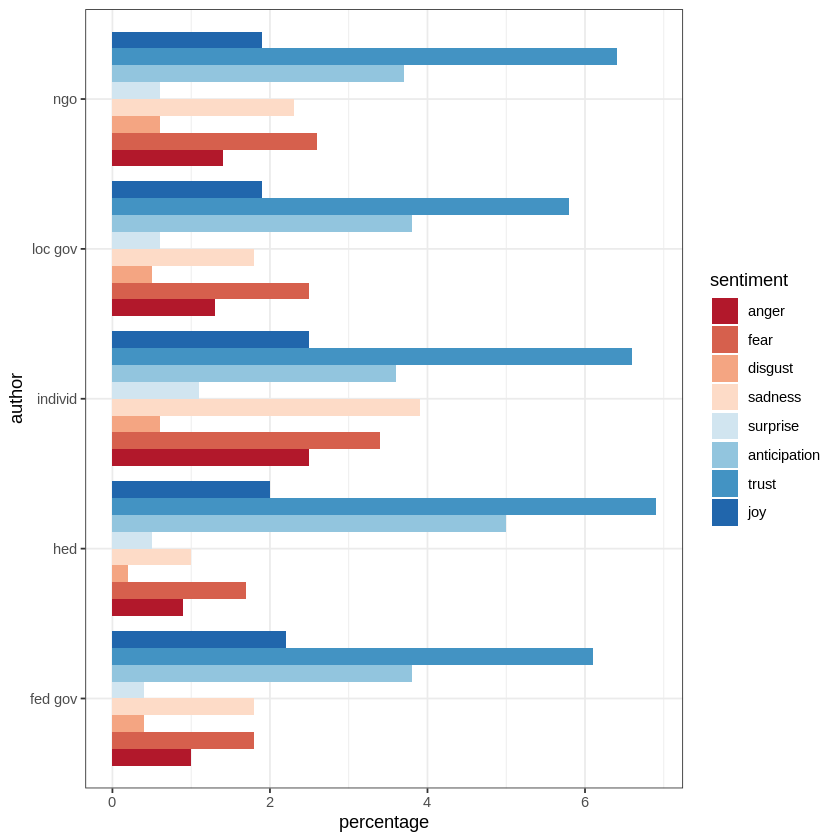

In [ ]:

senate_data_summary %>%
  dplyr::filter(sentiment != "positive",
                sentiment != "negative") %>%
  dplyr::mutate(sentiment = factor(sentiment, 
                                   levels = c("anger", "fear", "disgust", "sadness",
                                              "surprise", "anticipation", "trust", "joy"))) %>%
  ggplot(aes(author, percentage, fill = sentiment)) +    
  geom_bar(stat="identity", position=position_dodge()) + 
  scale_fill_brewer(palette = "RdBu") +
  theme_bw() +
  theme(legend.position = "right") +
  coord_flip()

# Identifying important emotives

We now check which words have contributed to the emotionality scores. In other words, we investigate which words are most important for the emotion scores within each group. For the sake of interpretability, we will remove several core emotion categories and also the polarity.

In [ ]:
senate_data_impw <- senate_data %>%
  dplyr::filter(!is.na(sentiment),
                sentiment != "anticipation",
                sentiment != "surprise",
                sentiment != "disgust",
                sentiment != "negative",
                sentiment != "sadness",
                sentiment != "positive") %>%
  dplyr::mutate(sentiment = factor(sentiment, levels = c("anger", "fear",  "trust", "joy"))) %>%
  dplyr::group_by(author) %>%
  dplyr::count(word, sentiment, sort = TRUE) %>%
  dplyr::group_by(author, sentiment) %>%
  dplyr::top_n(3) %>%
  dplyr::mutate(score = n/sum(n))

  head(senate_data_impw, 10)

Selecting by n


author,word,sentiment,n,score
<chr>,<chr>,<fct>,<int>,<dbl>
loc gov,government,fear,1113,0.6295249
ngo,government,fear,1103,0.5473945
ngo,inequality,anger,739,0.7412237
ngo,inequality,fear,739,0.3667494
loc gov,council,trust,651,0.5170770
ngo,council,trust,482,0.3868379
loc gov,inequality,anger,456,0.6477273
loc gov,inequality,fear,456,0.2579186
ngo,provide,trust,393,0.3154093


We can now visualize the top three words for the remaining core emotion categories.

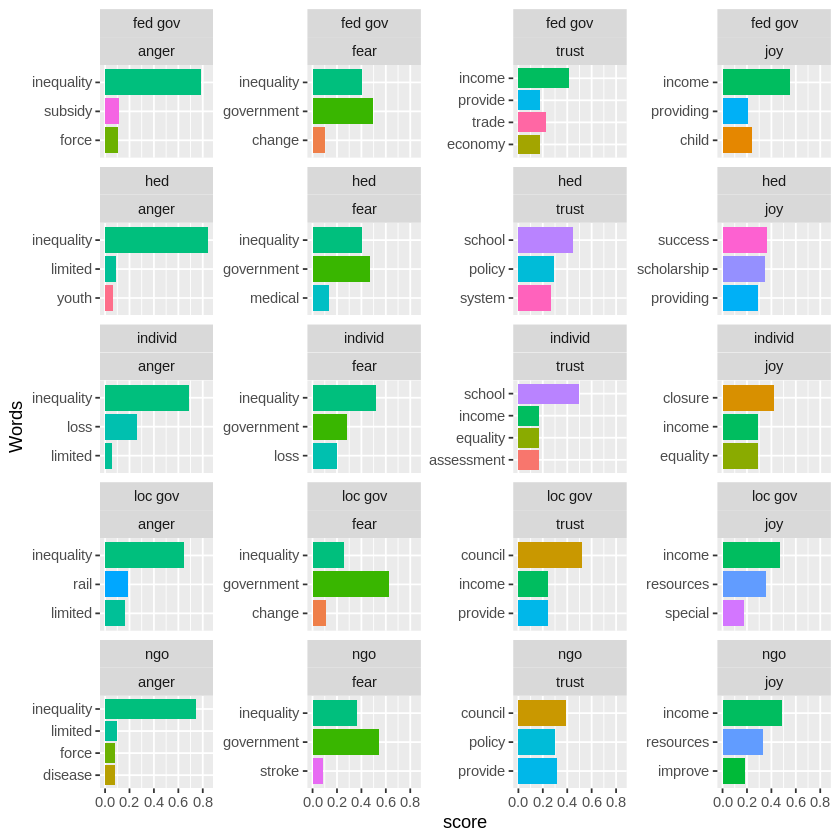

In [ ]:
senate_data_impw %>%
  dplyr::group_by(author) %>%
  slice_max(score, n = 20) %>%
  dplyr::arrange(desc(score)) %>%
  dplyr::ungroup() %>%
  ggplot(aes(x = reorder(word, score), y = score, fill = word)) +
  facet_wrap(author~sentiment, ncol = 4, scales = "free_y") +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(x = "Words")

# Calculating and dispalying polarity

Now, we visualize the polarity of each book, i.e. the ratio of the number of positive emotion words divided by the number of negative words.

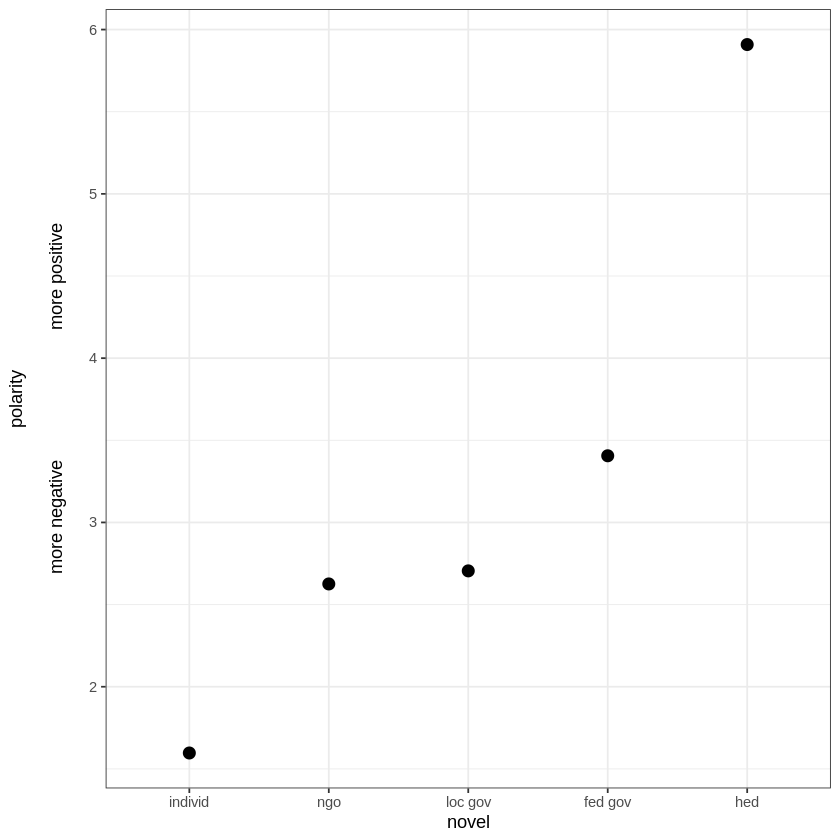

In [ ]:

senate_data_summary %>%
  dplyr::filter(sentiment == "positive" | sentiment == "negative") %>%
  dplyr::select(-percentage, -words) %>%
  dplyr::mutate(sentiment_sum = sum(sentiment_freq),
                positive = sentiment_sum-sentiment_freq) %>%
  dplyr::filter(sentiment != "positive") %>%
  dplyr::rename(negative = sentiment_freq) %>%
  dplyr::select(author, positive, negative) %>%
  dplyr::group_by(author) %>%
  dplyr::summarise(polarity = positive/negative) %>%
  ggplot(aes(reorder(author, polarity, mean), polarity)) +    
  geom_point(size = 3) + 
  theme_bw() +
  labs(y = "polarity\n\nmore negative                          more positive\n",
       x = "novel")


# Copyright 

This notebook is © Copyright 2021 Martin Schweinberger.


# Citation

Schweinberger, Martin. 2021 *Sentiment Analysis in R*. Brisbane: The University of Queensland. url: https://ladal.edu.au/sentiment.html.


# References

Mohammad, S. M., & Turney, P. D. (2013). Crowdsourcing a word–emotion association lexicon. *Computational intelligence*, 29(3), 436-465.

Silge, J., & Robinson, D. (2017). *Text mining with R: A tidy approach*. O'Reilly.
